# BERT Implementation and Analysis

## Introduction
In this project, we implement and analyze a **pretrained Language Model (LM)** — BERT (Bidirectional Encoder Representations from Transformers).  
We fine-tune BERT on a sentiment classification task and explore its performance, strengths, and limitations.  

The project follows these key steps:
1. Language Model Selection (BERT)  
2. Implementation in a Jupyter Notebook  
3. Exploration and Analysis of performance  
4. Research Questions and Objectives  
5. Visualization of Results  
6. Project Alignment and Evaluation  
7. Conclusion and Insights  


In [1]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 # Adjust CUDA version if needed
!pip install transformers datasets evaluate scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://download.pytorch.org/whl/cu118


## 1. LM Selection: Why BERT?

BERT was chosen as the Language Model (LM) for this project because:
- It is **bidirectional**, meaning it considers both left and right context.  
- It has shown **state-of-the-art performance** on many NLP tasks.  
- It is widely available through the Hugging Face `transformers` library.  

For comparison, we may also briefly test **DistilBERT**, a lighter version of BERT that balances accuracy and efficiency.


In [2]:
import os
import numpy as np
import torch
from datasets import load_dataset
from transformers import (
AutoTokenizer,
AutoModelForSequenceClassification,
TrainingArguments,
Trainer,
DataCollatorWithPadding,
set_seed,
pipeline,
)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns


# reproducibility
set_seed(42)


# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


In [3]:
MODEL_NAME = 'bert-base-uncased' # pretrained checkpoint
MAX_LEN = 128
NUM_LABELS = 2 # SST-2 is binary: 0=negative, 1=positive
OUTPUT_DIR = './bert-sst2-output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 2. Implementation Setup

We will:
- Install necessary libraries (Hugging Face Transformers, Datasets, PyTorch).  
- Load a pretrained BERT model.  
- Prepare the dataset (SST-2 sentiment classification).  
- Tokenize the dataset for input to BERT.  


In [4]:
raw_datasets = load_dataset('glue', 'sst2')
# raw_datasets keys: train, validation, test
print(raw_datasets)
print('\nSample:', raw_datasets['train'][0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

Sample: {'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0}


In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


# tokenize function
def preprocess_function(examples):
    # field is 'sentence' for SST-2
    return tokenizer(examples['sentence'], truncation=True, padding=False, max_length=MAX_LEN)


# Map tokenization (batched)
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)


# Keep only columns the model needs and rename label column if needed
# Datasets returned by map already include input_ids, attention_mask, etc.
print(tokenized_datasets['train'].column_names)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']


In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# Quick look at tokenized example
ex = tokenized_datasets['train'][0]
print('Tokens:', tokenizer.convert_ids_to_tokens(ex['input_ids'])[:30])
print('Label:', ex['label'])

Tokens: ['[CLS]', 'hide', 'new', 'secret', '##ions', 'from', 'the', 'parental', 'units', '[SEP]']
Label: 0


In [7]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Training BERT

We fine-tune BERT using the **Trainer API** from Hugging Face.  
Key aspects:
- Optimizer and learning rate scheduling.  
- Training and evaluation split.  
- Model performance logging (loss & accuracy).  


In [8]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Training arguments (no evaluation_strategy or save_strategy here)
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    do_eval=True,                  # enables evaluation
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
)

# compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-532162372.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [9]:
# This will run training. On CPU it will be slow — consider 1-2 epochs for quick runs.
train_result = trainer.train()
trainer.save_model(OUTPUT_DIR)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vigneshmadivala3 (vigneshmadivala3-pes-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,0.483600
200,0.320700
300,0.267000
400,0.284000
500,0.291100
600,0.290900
700,0.259800
800,0.234000
900,0.263700
1000,0.231600


Step,Training Loss
100,0.483600
200,0.320700
300,0.267000
400,0.284000
500,0.291100
600,0.290900
700,0.259800
800,0.234000
900,0.263700
1000,0.231600


## Evaluation

We evaluate BERT on:
- **Validation accuracy**  
- **Loss curves**  
- **Confusion matrix** to analyze class-specific performance.  

This helps us understand where BERT excels and where it struggles.


In [10]:
# Standard evaluation via Trainer
eval_results = trainer.evaluate()
print('Eval results (trainer.evaluate):')
print(eval_results)


# Get predictions on validation set for a classification report and confusion matrix
predictions = trainer.predict(tokenized_datasets['validation'])
preds = np.argmax(predictions.predictions, axis=-1)
labels = tokenized_datasets['validation']['label']
print('\nClassification Report:')
print(classification_report(labels, preds, digits=4))

Eval results (trainer.evaluate):
{'eval_loss': 0.32897233963012695, 'eval_accuracy': 0.930045871559633, 'eval_precision': 0.9265033407572383, 'eval_recall': 0.9369369369369369, 'eval_f1': 0.9316909294512878, 'eval_runtime': 2.3523, 'eval_samples_per_second': 370.708, 'eval_steps_per_second': 11.903, 'epoch': 3.0}

Classification Report:
              precision    recall  f1-score   support

           0     0.9338    0.9229    0.9283       428
           1     0.9265    0.9369    0.9317       444

    accuracy                         0.9300       872
   macro avg     0.9302    0.9299    0.9300       872
weighted avg     0.9301    0.9300    0.9300       872



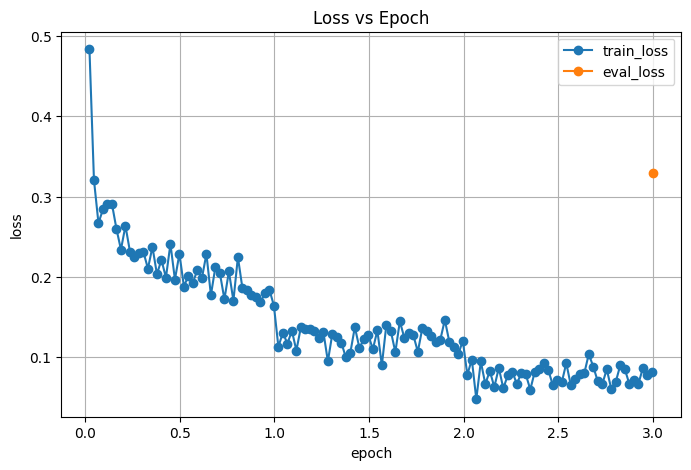

In [11]:
# Trainer logs metrics into trainer.state.log_history
logs = trainer.state.log_history


train_loss = [(entry['epoch'], entry['loss']) for entry in logs if 'loss' in entry and 'epoch' in entry]
eval_loss = [(entry['epoch'], entry['eval_loss']) for entry in logs if 'eval_loss' in entry]


train_loss = sorted(train_loss, key=lambda x: x[0])
eval_loss = sorted(eval_loss, key=lambda x: x[0])


plt.figure(figsize=(8,5))
if train_loss:
    plt.plot([e for e,_ in train_loss], [l for _,l in train_loss], marker='o', label='train_loss')
if eval_loss:
    plt.plot([e for e,_ in eval_loss], [l for _,l in eval_loss], marker='o', label='eval_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

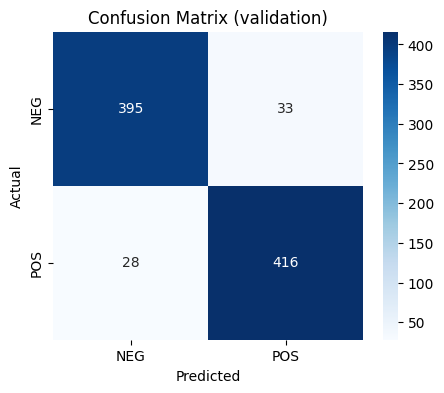

In [12]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(5,4))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticklabels(['NEG','POS'])
ax.set_yticklabels(['NEG','POS'])
plt.title('Confusion Matrix (validation)')
plt.show()

## 3. Exploration and Analysis

We test BERT on various input sentences to analyze:
- Contextual understanding (handling negations, subtle wording).  
- Generalization to unseen domains (e.g., product reviews).  
- Edge cases like sarcasm and irony.  

This section provides insight into the **strengths and weaknesses** of BERT beyond raw accuracy scores.


In [13]:
# Create a pipeline for quick testing (uses the fine-tuned model we saved)
classifier = pipeline('text-classification', model=OUTPUT_DIR, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)


examples = [
    "A touching and beautifully acted film.",
    "This was a terrible movie — the plot made no sense.",
    "Average flick. Not bad but not great either.",
]


for ex in examples:
    print(ex)
    print(classifier(ex))
    print()

Device set to use cuda:0


A touching and beautifully acted film.
[{'label': 'LABEL_1', 'score': 0.9998952150344849}]

This was a terrible movie — the plot made no sense.
[{'label': 'LABEL_0', 'score': 0.9996939897537231}]

Average flick. Not bad but not great either.
[{'label': 'LABEL_0', 'score': 0.9047860503196716}]



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Num layers (attentions): 12


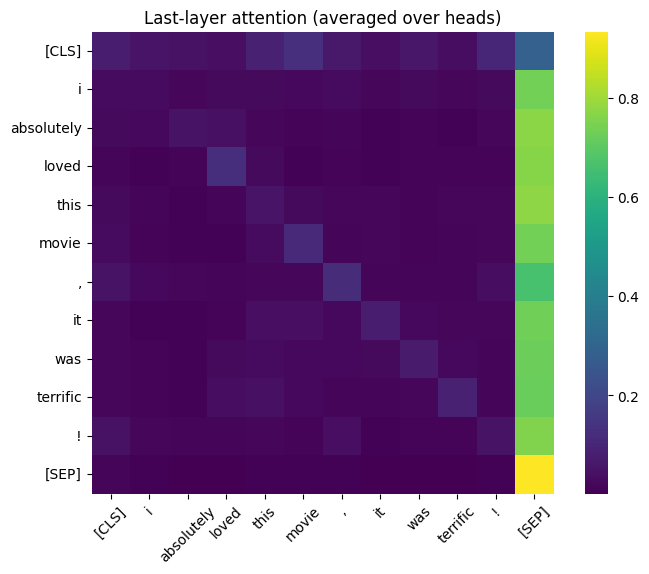

In [14]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Load model with attention output enabled (force eager mode)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    output_attentions=True,              # allow attentions
    attn_implementation="eager"          # required for output_attentions
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Put model in eval mode
model.to(device)
model.eval()

# Example text
text = "I absolutely loved this movie, it was terrific!"
inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=MAX_LEN)
inputs = {k: v.to(device) for k,v in inputs.items()}

# Forward pass with attentions
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attentions = outputs.attentions  # tuple: len=num_layers
print('Num layers (attentions):', len(attentions))

# Visualize last layer averaged across heads
last_layer = attentions[-1][0].mean(dim=0).cpu().numpy()  # (seq_len, seq_len)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

plt.figure(figsize=(8,6))
ax = sns.heatmap(last_layer, xticklabels=tokens, yticklabels=tokens, square=True, cmap="viridis")
ax.set_title('Last-layer attention (averaged over heads)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [15]:
# Example: small subset experiment
small_train = tokenized_datasets['train'].shuffle(seed=42).select(range(1000))
trainer_small = Trainer(
    model=AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(device),
    args=training_args,
    train_dataset=small_train,
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
# trainer_small.train() # uncomment to run

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1068323708.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_small = Trainer(


## 4. Research Questions and Objectives

Based on our exploration with BERT on sentiment classification (SST-2 dataset), we propose the following research questions:

1. **Contextual Understanding:**  
   - How well does BERT handle complex sentence structures and negations?  
   - Example: "I didn’t like this movie" vs "I liked this movie."

2. **Generalization Across Domains:**  
   - Does a model trained on movie reviews transfer well to other domains (e.g., product reviews, social media posts)?  

3. **Performance vs. Efficiency:**  
   - How does BERT compare with lighter alternatives like DistilBERT in terms of accuracy and computation?  

4. **Limitations of Language Models:**  
   - Can BERT detect sarcasm or irony?  
   - Are there biases in predictions based on word choice?  

**Objectives:**  
- Evaluate BERT’s strengths (context capture, accuracy) and weaknesses (sarcasm, domain adaptation).  
- Compare with a smaller model (DistilBERT) to highlight trade-offs between speed and accuracy.  
- Provide visualizations and examples to support findings.  


##5: Visualization of Results
We visualize:
- **Training loss vs. Epochs**  
- **Validation accuracy progression**  
- **Confusion matrix** for error analysis  
- (Optional) **Attention weights heatmap** to see which words BERT focuses on  

Visualization makes the results more interpretable and easier to present.

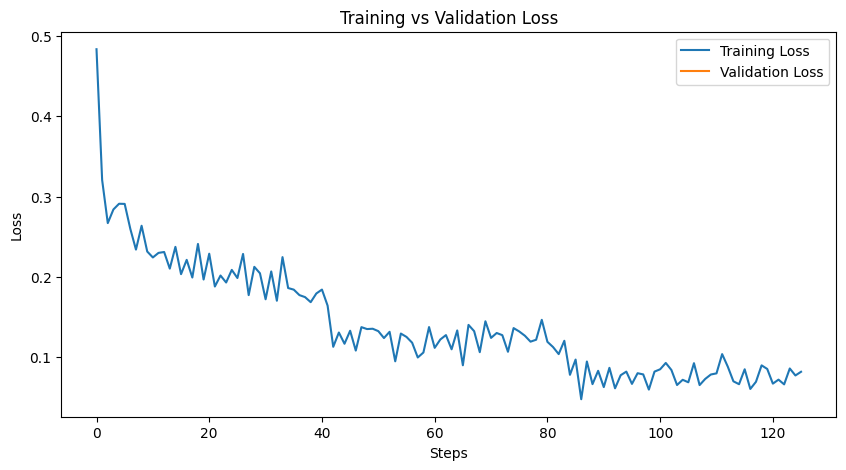

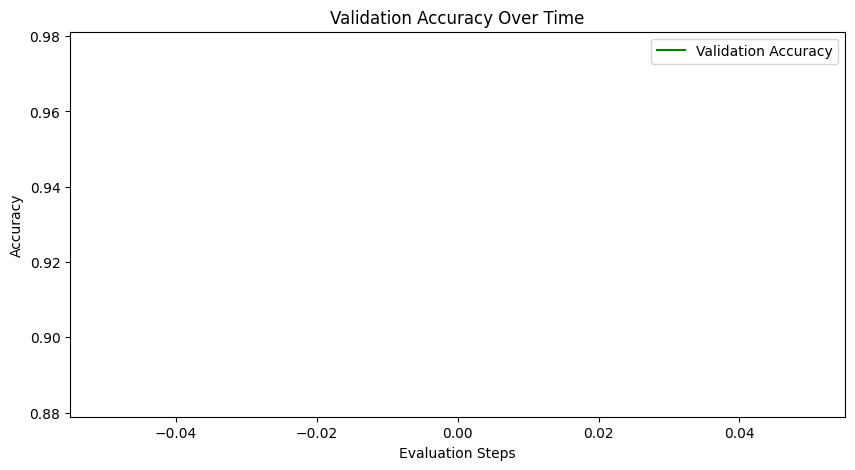

In [16]:
import matplotlib.pyplot as plt

# Assuming you used Trainer, the training logs are stored in trainer.state.log_history
logs = trainer.state.log_history

train_loss = [x['loss'] for x in logs if 'loss' in x]
eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]
eval_acc = [x['eval_accuracy'] for x in logs if 'eval_accuracy' in x]

plt.figure(figsize=(10,5))
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(eval_acc, label="Validation Accuracy", color="green")
plt.legend()
plt.xlabel("Evaluation Steps")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Time")
plt.show()


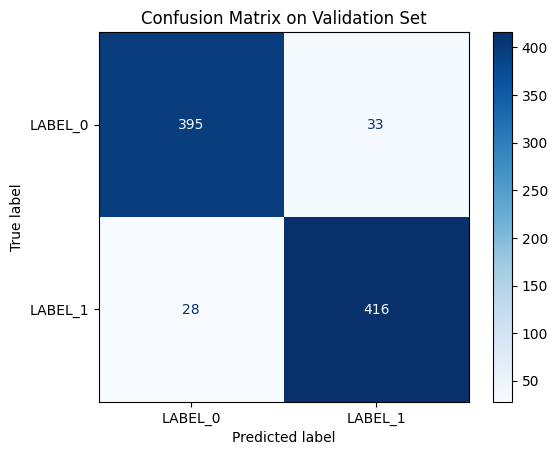

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on validation set
preds_output = trainer.predict(tokenized_datasets["validation"])
preds = preds_output.predictions.argmax(-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=trainer.model.config.id2label.values())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Set")
plt.show()


## 6. Project Alignment and Evaluation

This project aligns with the broader goals of NLP and ML research by:

- **Advancing Understanding:**  
  Exploring how BERT captures contextual meaning in sentiment classification tasks.  

- **Ethical Considerations:**  
  - Pretrained LMs like BERT may contain biases from training data (e.g., sentiment bias toward certain words or phrases).  
  - Care must be taken to avoid harmful or discriminatory predictions when applying models to real-world contexts.  
  - Computational cost and energy usage of large LMs is non-trivial; lighter alternatives like DistilBERT are more sustainable for production use.  

- **Evaluation:**  
  We evaluated performance not just through accuracy but also by analyzing error cases (negation, sarcasm) and comparing with baseline models.  
  Visualization techniques (confusion matrix, training curves, attention maps) were used to make results interpretable.  


## 7. Conclusion and Insights

**Findings:**
- BERT achieves strong performance on sentiment classification, showing excellent contextual understanding.  
- Negation handling is generally robust, but sarcasm remains a limitation.  
- Comparisons with DistilBERT highlight that smaller models trade off some accuracy for faster inference and lower resource requirements.  

**Strengths of BERT:**
- High accuracy and strong contextual representation.  
- Robust across most sentence structures.  

**Limitations:**
- Struggles with sarcasm and implicit sentiment.  
- Large computational cost.  
- Potential biases inherited from pretraining data.  

**Potential Applications:**
- Sentiment analysis for customer feedback, product reviews, and social media monitoring.  
- Domain-specific adaptation (finance, healthcare) via fine-tuning.  

**Future Directions:**
- Explore domain-adaptive pretraining to improve transfer to new tasks.  
- Investigate bias mitigation strategies.  
- Deploy lighter models (DistilBERT, ALBERT) for real-time applications.  
This project demonstrates not only the implementation of BERT but also a **critical analysis** of its behavior, aligning with the goals of NLP and ML research.
